In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mercaricombined/output101.csv
/kaggle/input/mercari/sample_submission.csv
/kaggle/input/mercari/test.tsv
/kaggle/input/mercari/train.tsv


In [2]:
data = pd.read_csv("../input/mercari/train.tsv", sep='\t')

first sentiment analysis then remove all and then find length.

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Exploratory Data Analysis (EDA)

In [4]:
stats = []
for col in data.columns:
    stats.append((col,data[col].nunique(), data[col].isnull().sum(), data[col].isnull().sum() * 100 / data.shape[0], data[col].dtype))
    
stats_df = pd.DataFrame(stats, columns=['Feature','Unique_values','null count', 'Percentage of missing values', 'type'])
# gives a table containg 'Unique_values','null count', 'Percentage of missing values', 'type' for each feature

In [5]:
stats_df

,Feature,Unique_values,null count,Percentage of missing values,type
0,train_id,1037774,0,0.000000,int64
1,name,877889,0,0.000000,object
2,item_condition_id,5,0,0.000000,int64
3,category_name,1258,4382,0.422250,object
4,brand_name,4413,442947,42.682414,object
5,price,760,0,0.000000,float64
6,shipping,2,0,0.000000,int64
7,item_description,904740,2,0.000193,object


In [6]:
data['category_name'].fillna('missing', inplace = True) # filling the missing values

In [7]:
data['brand_name'].fillna('missing', inplace = True)

In [8]:
data['item_description'].fillna('missing', inplace = True)

we found that coulms category_name brand name and description have null values so we have filled those with missing

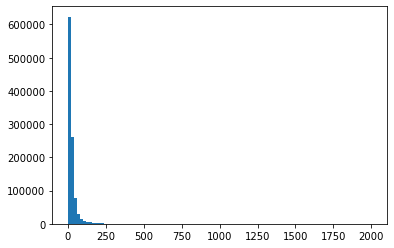

In [9]:
plt.hist(data.price, bins = 100)
plt.show() #### highly skewed

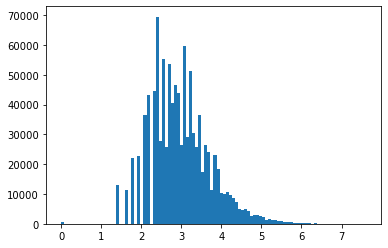

In [10]:
data['log']=np.log(data['price']+1)
plt.hist(data.log, bins = 100)
plt.show()  ####removing skewness in price

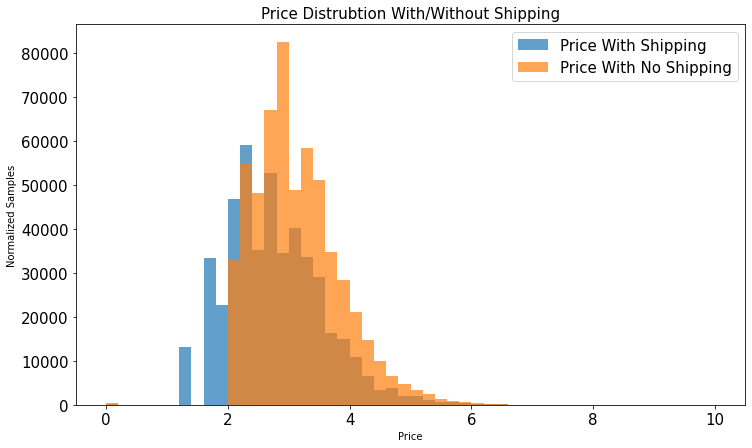

In [11]:
shipping = data[data['shipping']==1]['log']
no_shipping = data[data['shipping']==0]['log']

plt.figure(figsize=(12,7))
plt.hist(shipping, bins=50, range=[0,10], alpha=0.7, label='Price With Shipping')
plt.hist(no_shipping, bins=50, range=[0,10], alpha=0.7, label='Price With No Shipping')
plt.title('Price Distrubtion With/Without Shipping', fontsize=15)
plt.xlabel('Price')
plt.ylabel('Normalized Samples')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()

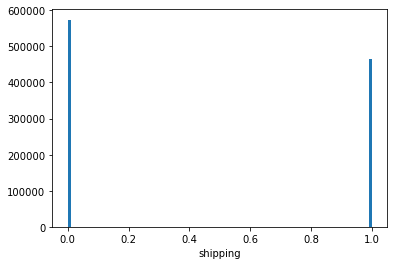

In [12]:

plt.hist(data.shipping, bins = 100)
plt.xlabel('shipping')
plt.show()

this is how price varies accourding to shipping

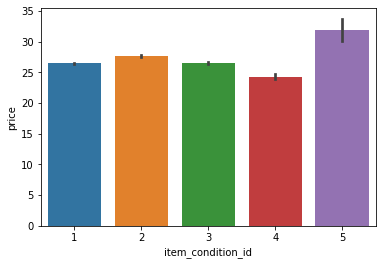

In [13]:
sns.barplot(x = data.item_condition_id, y = data.price )

as expected best condition has better price.

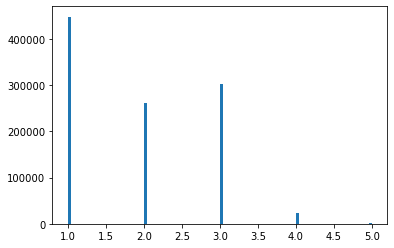

In [14]:

plt.hist(data.item_condition_id, bins = 100)
plt.show()

In [15]:

#function to split the category into 3 sub categorys
def catsp(col):
    try:
        inp=col
        out1,out2,out3=inp.split('/')
        return out1,out2,out3
    except:
        return("Not given","Not given","Not given")
    

In [16]:
data['sub1'],data['sub2'],data['sub3']=zip(*data['category_name'].apply(lambda x:catsp(x)))

we have seen in the data.describe() that catogery_name has 3 sub catogrys so we have split them and filling the empty with not given.

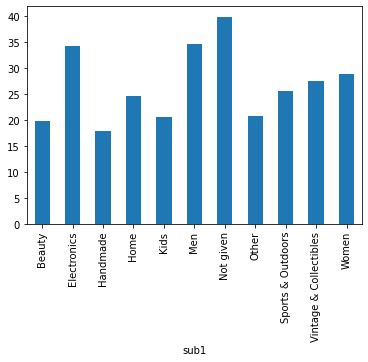

In [17]:
data.groupby('sub1')['price'].mean().plot(kind='bar')
plt.show()

we can see how price is varying in this sub category.

In [18]:
data.groupby("brand_name")["price"].sum().sort_values(ascending=False)

brand_name
missing              9354847.0
Nike                 1165053.0
PINK                  989724.0
Apple                 886846.5
Victoria's Secret     782378.0
                       ...    
Workman                    3.0
Old Glory                  3.0
Kids Only                  3.0
Biore                      3.0
CM Style Fashion           0.0
Name: price, Length: 4414, dtype: float64

In [19]:
data.groupby("brand_name")["price"].mean().sort_values(ascending=False)

brand_name
Proenza Schouler             645.500000
Mackage                      450.000000
Demdaco                      429.000000
Auto Meter                   344.000000
MCM Worldwide                340.096154
                                ...    
Pedialyte                      3.000000
AA Aquarium                    3.000000
Twilight Gypsy Collective      3.000000
Peanut Shell                   3.000000
CM Style Fashion               0.000000
Name: price, Length: 4414, dtype: float64

we have observed that nike has the higest sales. but it isnt in the top 5 of the mean price. 

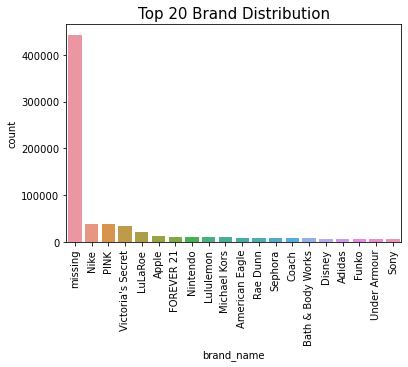

In [20]:
b20 = data['brand_name'].value_counts()[0:20].reset_index().rename(columns={'index': 'brand_name', 'brand_name':'count'})
ax = sns.barplot(x="brand_name", y="count", data=b20)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('Top 20 Brand Distribution', fontsize=15)
plt.show()

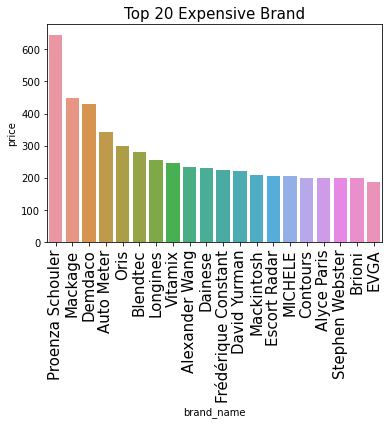

In [21]:
# Display Top 20 Expensive Brands By Mean Price
top20_brand = data.groupby('brand_name', axis=0).median()
df_expPrice = pd.DataFrame(top20_brand.sort_values('price', ascending = False)['price'][0:20].reset_index())
ax = sns.barplot(x="brand_name", y="price", data=df_expPrice)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90, fontsize=15)
ax.set_title('Top 20 Expensive Brand', fontsize=15)
plt.show()

graphical representation of above data

# Sentiment Analyzer

for the item decription we are using a function SentimentIntensityAnalyzer() which gives a sentimantal analysis of the description. so that we get to know which descripition is good then it must be a good product and will have a better price. this function will analyize the text in four differnt formats namely negitive, possitive,neutral, compound.


In [22]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm import tnrange,tqdm_notebook
def generate_sentiment_scores(data):  
    sid = SentimentIntensityAnalyzer()
    scores = []
    for sentence in tqdm_notebook(data):
        for_senti=sentence
        sentence_sentiment_score = sid.polarity_scores(for_senti)
        scores.append(sentence_sentiment_score)
    return scores
# the above function analyses the given text and return 4 values as a dictionary

/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [23]:
sentimental_names1 = generate_sentiment_scores(data['item_description'])#calling the sentiment analyzer


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [24]:
data['sentiment'] = sentimental_names1 #this coulum has a dicitonary we need to split them to different colums


In [25]:
temp=data['sentiment']
dt0 = list(temp.items())
an_array0 = np.array(dt0)
aa20={}
for i in range(0,1037774):
    aa20[i]=an_array0[i][1]


In [26]:
aan20=list(range(0,1037774))
aap20=list(range(0,1037774))
aanu20=list(range(0,1037774))
aac20=list(range(0,1037774))

for i in range(0,1037774):
    aan20[i]=aa20[i]['neg']         #splitting the dictonary into four different lists
    aap20[i]=aa20[i]['pos']
    aanu20[i]=aa20[i]['neu']
    aac20[i]=aa20[i]['compound']


In [27]:
data['negg']=aan20   #assigning lists to the respective colums 
data['poss']=aap20
data['comp']=aac20
data['neu']=aanu20

# Text Preprocessing

In [29]:
from string import punctuation
punctuation_symbols = []
for symbol in punctuation: # intializing punctuation symbols
    punctuation_symbols.append((symbol, ''))

In [30]:
import re

def decontracted(phrase):  # function that  decontracting contracted strings

   
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [31]:
def text_preprocess(text):
    text = decontracted(text)
    text = re.sub("[\-\\\n\t]", " ", text)  #Regex to remove all \n, \t, - and \
    text = re.sub("[^A-Za-z0-9]", " ", text)  #Regex to remove all the words except A-Za-z0-9
    text = re.sub('\s\s+', ' ', str(text))  #Regex to remove all the extra spaces
    text = text.lower() #Converts everything to lower case
    return text

In [32]:
from nltk.stem.porter import PorterStemmer

porter = PorterStemmer() #function used for stemming

In [33]:
import string #function to rempove punctuation
def remove_punctuation(sentence: str) -> str:
    return sentence.translate(str.maketrans('', '', string.punctuation))

In [34]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
def remove_stop_words(x):   #function to remove stopwords
    x = ' '.join([i for i in x.lower().split(' ') if i not in stop])
    return x

In [35]:
#text preprocessing for item_description 
data['item_description'] = data['item_description'].apply(remove_stop_words)
data['item_description'] = data['item_description'].apply(remove_punctuation) 
data['item_description'] = data['item_description'].apply(porter.stem)
data['item_desc_preprocess'] = data['item_description'].apply(lambda x : text_preprocess(x))


In [36]:
# text preporcessing for name
data['name']=data['name'].apply(remove_stop_words)
data['name']=data['name'].apply(remove_punctuation)
data['name'] = data['name'].apply(porter.stem)
data['name_preprocess'] = data['name'].apply(lambda x : text_preprocess(x))

we also felt that length of the item decription and name plays a role in price hence we calculated it.

In [37]:
no_desc_string = 'missing'  
def text_length(text, no_desc_string): # function to calculate length of the text ie, no fo words
    try:
        if text in no_desc_string:
            return 0
        else:
            return len(text.split())
    except:
        return 0

In [38]:
#calcualting length of the pre processed text of item_description and name 
data['item_pre_length'] = data['item_desc_preprocess'].apply(lambda x : text_length(x, no_desc_string))
data['namepre_length'] = data['name_preprocess'].apply(lambda x : text_length(x, no_desc_string))


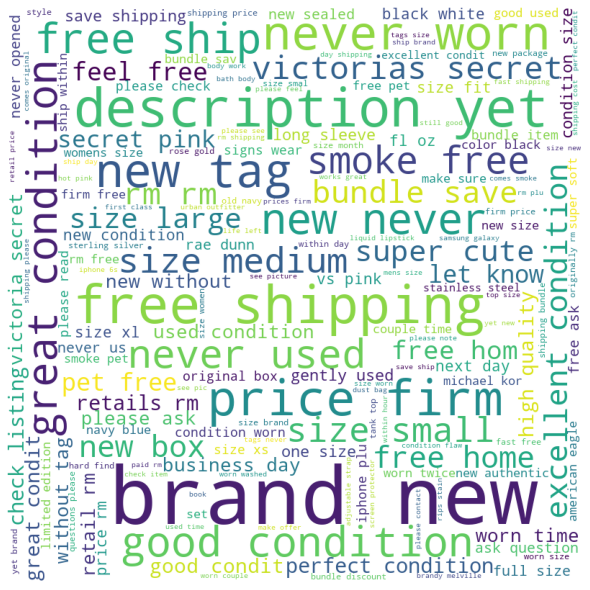

In [39]:
##below pic shows which are the words with high freqency. bigger size means higher its freqency.

from wordcloud import WordCloud
comment_words = '' 
for val in data.item_desc_preprocess: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()  

# Feature Extraction

below is the code for how we implimented label encoding for sub category 1

In [40]:
initial_sub1 = data.groupby('sub1', axis=0).median()
sub1_inorder1 = pd.DataFrame(initial_sub1.sort_values('price', ascending = False)['price'].reset_index())
sf1=sub1_inorder1["sub1"] #sf1 is a list that contains them in desending median price

In [41]:
valsub1=list(range(0,11))
dicts1=dict(zip(sf1, valsub1)) ### forms a dictionary for list in the same order

In [42]:
def funbs1(x): # function that impliments label encoding
    try:
        return dicts1[x]
    except:
        xxx=5
        return xxx 

In [43]:
data['sub1v']=data['sub1'].apply(lambda x : funbs1(x)) # label encoding

same process will be followed for sub2 sub3 and brand_name. as the results are not upto the mark we choose to shift to one-hot encoding.

# One-hot encoding for *sub1,sub2,sub3,brand_name*

In [44]:
from sklearn import preprocessing

In [45]:
bbb=np.reshape(np.array(data.brand_name), (-1,1))
sss1=np.reshape(np.array(data.sub1), (-1,1))
sss2=np.reshape(np.array(data.sub2), (-1,1))
sss3=np.reshape(np.array(data.sub3), (-1,1))

In [46]:
onehot=preprocessing.OneHotEncoder(handle_unknown='ignore')
bran=onehot.fit_transform(bbb)

In [47]:
onehot1=preprocessing.OneHotEncoder(handle_unknown='ignore')
su1=onehot1.fit_transform(sss1)


In [48]:
onehot2=preprocessing.OneHotEncoder(handle_unknown='ignore')
su2=onehot2.fit_transform(sss2)


In [49]:
onehot3=preprocessing.OneHotEncoder(handle_unknown='ignore')
su3=onehot3.fit_transform(sss3)


# tfidf and bag of words

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer1 = TfidfVectorizer(ngram_range=(1,3),min_df=10,max_features=500000).fit(data['item_desc_preprocess'])

data_desc_tfidf = vectorizer1.transform(data['item_desc_preprocess'])


In [53]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1,2),max_features=150000).fit(data['name_preprocess'])

data_name = vectorizer.transform(data['name_preprocess'])

In [59]:
feature_cols=['item_condition_id','shipping','item_pre_length', 'namepre_length', 'negg', 'poss', 'comp', 'neu']

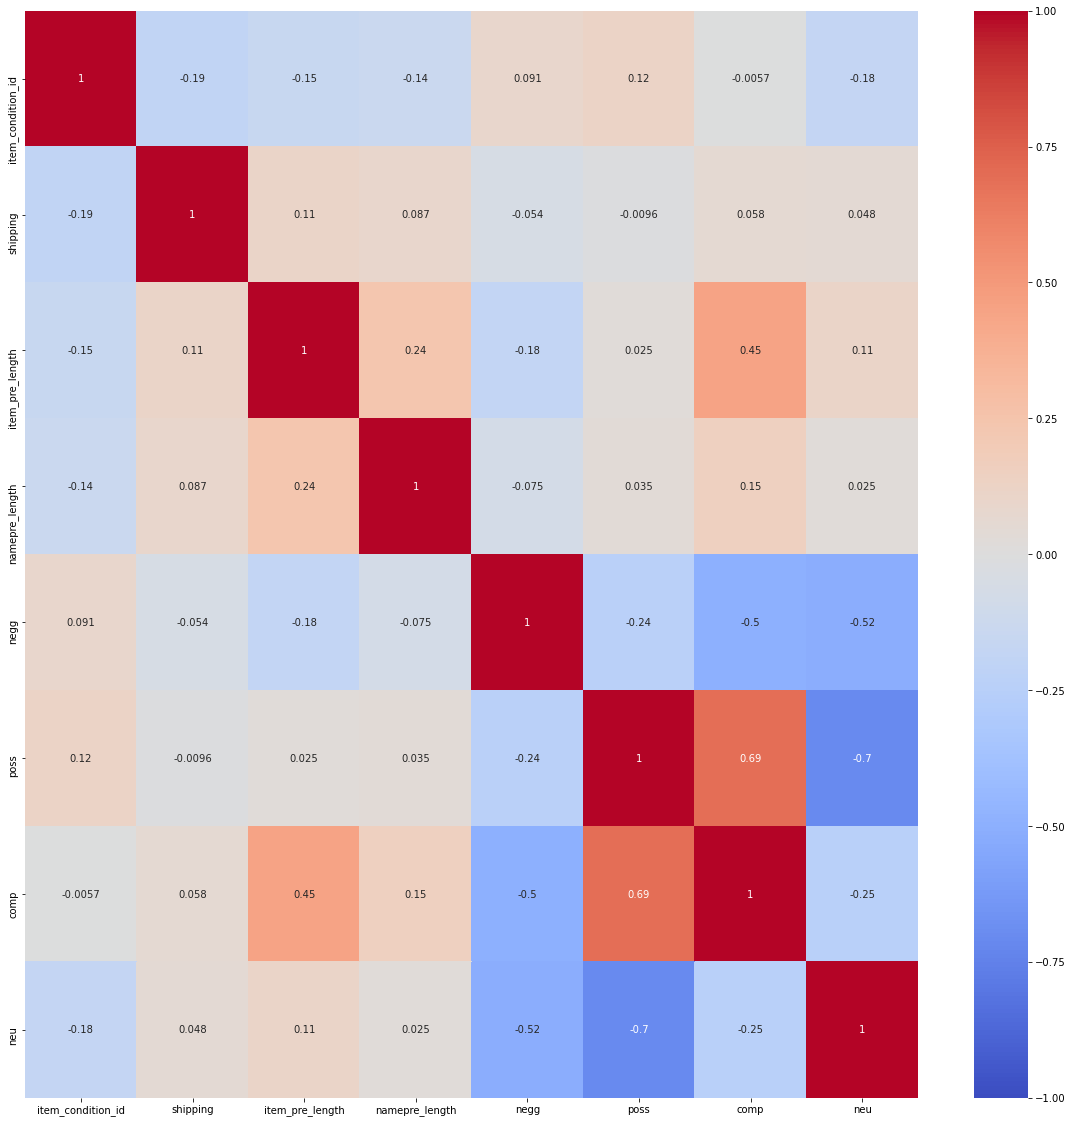

In [60]:
teemp=data[feature_cols] # finding corealtion between features
plt.figure(figsize=(20,20))
sns.heatmap(teemp.corr(), vmin=-1, cmap="coolwarm", annot=True)

In [61]:
from scipy.sparse import vstack, hstack, csr_matrix

xt = csr_matrix(pd.get_dummies(data[feature_cols], sparse=True).values)

In [62]:
sparse_merge = hstack((xt,data_name, data_desc_tfidf,bran,su1,su2,su3)).tocsr()
# this is our x_trian

In [63]:
y_train=data['log'] #target variable
y_train=np.reshape(np.array(data.log), (-1,1))
y_train

# Test data

In [69]:
testdata = pd.read_csv("../input/mercari/test.tsv", sep='\t')

In [70]:
stats = []
for col in testdata.columns:
    stats.append((col,testdata[col].nunique(), testdata[col].isnull().sum(), testdata[col].isnull().sum() * 100 / testdata.shape[0], testdata[col].dtype))
    
stats_df = pd.DataFrame(stats, columns=['Feature','Unique_values','null count', 'Percentage of missing values', 'type'])
stats_df
# gives a table containg 'Unique_values','null count', 'Percentage of missing values', 'type' for each feature

,Feature,Unique_values,null count,Percentage of missing values,type
0,id,444761,0,0.000000,int64
1,name,394296,0,0.000000,object
2,item_condition_id,5,0,0.000000,int64
3,category_name,1167,1945,0.437314,object
4,brand_name,3365,189735,42.659990,object
5,shipping,2,0,0.000000,int64
6,item_description,394219,2,0.000450,object


In [71]:
testdata['category_name'].fillna('missing', inplace = True) #filling null values

In [72]:
testdata['item_description'].fillna('missing', inplace = True)

In [73]:
testdata['brand_name'].fillna('missing', inplace = True)

In [74]:
#splliting category_name
testdata['sub1'],testdata['sub2'],testdata['sub3']=zip(*testdata['category_name'].apply(lambda x:catsp(x)))

# Sentiment Analyzer for test data

In [76]:
sentimental_names2 = generate_sentiment_scores(testdata['item_description'])#calling the sentiment analyzer


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [77]:
testdata['sentiment'] = sentimental_names2 #this coulum has a dicitonary we need to split them to different colums

In [78]:
tempo=testdata['sentiment']
dt = list(tempo.items())
an_array = np.array(dt)
aa2={}
for i in range(0,444761):
    aa2[i]=an_array[i][1]

In [79]:
aan2=list(range(0,444761))
aap2=list(range(0,444761))
aanu2=list(range(0,444761))
aac2=list(range(0,444761))

for i in range(0,444761):
    aan2[i]=aa2[i]['neg']         #splitting the dictonary into four different lists
    aap2[i]=aa2[i]['pos']
    aanu2[i]=aa2[i]['neu']
    aac2[i]=aa2[i]['compound']

In [80]:
testdata['negg']=aan2   #assigning lists to the respective colums 
testdata['poss']=aap2
testdata['comp']=aac2
testdata['neu']=aanu2


In [82]:
testdata

,id,name,item_condition_id,category_name,brand_name,shipping,item_description,sub1,sub2,sub3,sentiment,negg,poss,comp,neu
0,1048243,Herschel Retreat Backpack,2,"Men/Men's Accessories/Backpacks, Bags & Briefc...",Urban Outfitters,0,In great condition! Only issue is magnet that ...,Men,Men's Accessories,"Backpacks, Bags & Briefcases","{'neg': 0.054, 'neu': 0.832, 'pos': 0.113, 'co...",0.054,0.113,0.3880,0.832
1,86986,2 pairs of Lebron,3,Men/Shoes/Athletic,Nike,1,Lebron soldier 10 size 10.5 9/10 condition Leb...,Men,Shoes,Athletic,"{'neg': 0.136, 'neu': 0.864, 'pos': 0.0, 'comp...",0.136,0.000,-0.2960,0.864
2,698316,Mario Kart Double Dash with bonus disc,3,Vintage & Collectibles/Electronics/Video Game,Nintendo,1,Good shape work no problem,Vintage & Collectibles,Electronics,Video Game,"{'neg': 0.5, 'neu': 0.204, 'pos': 0.296, 'comp...",0.500,0.296,-0.2500,0.204
3,268868,Tokidoki unicorno kaiju and strawberry,2,Vintage & Collectibles/Collectibles/Figurine,tokidoki,1,Both new with foil and box.,Vintage & Collectibles,Collectibles,Figurine,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,0.000,0.0000,1.000
4,1360398,"Like Ugg Cardy, grey knit top boot",2,Women/Shoes/Boots,missing,0,"Brand new, not even a foot near them! Size 8 b...",Women,Shoes,Boots,"{'neg': 0.0, 'neu': 0.916, 'pos': 0.084, 'comp...",0.000,0.084,0.3365,0.916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444756,316678,ivory ella tie dye,2,Women/Tops & Blouses/T-Shirts,Ivory Ella,0,"tags- american eagle, aeropostale, hollister, ...",Women,Tops & Blouses,T-Shirts,"{'neg': 0.0, 'neu': 0.914, 'pos': 0.086, 'comp...",0.000,0.086,0.5267,0.914
444757,795624,5 Tier Shoe organizer,1,"Home/Storage & Organization/Racks, Shelves & D...",missing,1,5 tier shoe organizer Brand new never used 100...,Home,Storage & Organization,"Racks, Shelves & Drawers","{'neg': 0.0, 'neu': 0.93, 'pos': 0.07, 'compou...",0.000,0.070,0.7777,0.930
444758,765638,Toy Bundle (FUN fun FUN fun FUN 4 baby),3,Kids/Toys/Baby & Toddler Toys,Fisher-Price,0,Includes: Fisher-Price Cozy Fit Tummy Wedge ~ ...,Kids,Toys,Baby & Toddler Toys,"{'neg': 0.042, 'neu': 0.742, 'pos': 0.216, 'co...",0.042,0.216,0.8611,0.742
444759,766765,ADIDAS JOGGING SUIT,3,Women/Athletic Apparel/Tracksuits & Sweats,Adidas,0,Women comfortable Adidas 2pc jogging suit Incl...,Women,Athletic Apparel,Tracksuits & Sweats,"{'neg': 0.115, 'neu': 0.547, 'pos': 0.338, 'co...",0.115,0.338,0.9086,0.547


# Text Preprocessing for test data

In [83]:
#text preprocessing for item_description of testdata
testdata['item_description'] = testdata['item_description'].apply(remove_stop_words)
testdata['item_description'] = testdata['item_description'].apply(remove_punctuation) 
testdata['item_description'] = testdata['item_description'].apply(porter.stem)
testdata['item_desc_preprocess'] = testdata['item_description'].apply(lambda x : text_preprocess(x))

In [84]:
# text preporcessing for name of testdata
testdata['name']=testdata['name'].apply(remove_stop_words)
testdata['name']=testdata['name'].apply(remove_punctuation)
testdata['name'] = testdata['name'].apply(porter.stem)
testdata['name_preprocess'] = testdata['name'].apply(lambda x : text_preprocess(x))

In [85]:
#calcualting length of the pre processed text of item_description and name of testdata
testdata['item_pre_length'] = testdata['item_desc_preprocess'].apply(lambda x : text_length(x, no_desc_string))
testdata['namepre_length'] = testdata['name_preprocess'].apply(lambda x : text_length(x, no_desc_string))

# Feature Extraction

In [87]:
tbbb=np.reshape(np.array(testdata.brand_name), (-1,1))
tsss1=np.reshape(np.array(testdata.sub1), (-1,1))
tsss2=np.reshape(np.array(testdata.sub2), (-1,1))
tsss3=np.reshape(np.array(testdata.sub3), (-1,1))

In [88]:
tbran=onehot.transform(tbbb)
tsu1=onehot1.transform(tsss1)
tsu2=onehot2.transform(tsss2) # one hot encoding of catogorical data
tsu3=onehot3.transform(tsss3)

In [89]:
testdata_desc_tfidf = vectorizer1.transform(testdata['item_desc_preprocess'])# tfidf on item_description
testdata_name = vectorizer.transform(testdata['name_preprocess'])# bag of words on name

In [94]:
txt = csr_matrix(pd.get_dummies(testdata[feature_cols], sparse=True).values)

In [95]:
tsparse_merge = hstack((txt,testdata_name, testdata_desc_tfidf,tbran,tsu1,tsu2,tsu3)).tocsr()
#this is our x_test

# Regression

In [96]:
########### code used for linear regression ########

#import sklearn
#from sklearn.linear_model import LinearRegression
#lm = LinearRegression()
#lm.fit(sparse_merge, y_train)
#c_pred = lm.intercept_
#c_pred = lm.intercept_

#y_pred = lm.predict(tsparse_merge)
#y_pred


In [103]:
#####code used to find the best alpha for ridge regression##########

#from sklearn.linear_model import Ridge 
#from sklearn.model_selection import GridSearchCV

#ridge=Ridge() 
#parameters={'alpha':[0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7]} 
#ridge_regressor=GridSearchCV(ridge,parameters,scoring='neg_mean_squared_error',cv=5) 
#ridge_regressor.fit(sparse_merge, y_train)

#print(ridge_regressor.best_params_) 
#print(ridge_regressor.best_score_)

##### we got alpha=5.5 for normal ridge regression #### 

In [104]:
#we got alpha=5.5 for normal ridge regression 

In [105]:
# code for ridge regression
from sklearn.linear_model import Ridge
model = Ridge(alpha =2)  ### for ensembling we got best acuuracy for alpha=2
model.fit(sparse_merge, y_train)
preds= model.predict(tsparse_merge)
preds

array([[3.70897342],
       [4.12031939],
       [3.1967096 ],
       ...,
       [3.33862872],
       [3.21828428],
       [3.11282199]])

In [106]:
###########code used for Xgboost#######3
#from xgboost import XGBRegressor
#from sklearn.model_selection import GridSearchCV

#params = { 
#          'gamma':[i/10.0 for i in range(3,8,2)],  
#          'max_depth': [4,8,16]}

#xgb = XGBRegressor() 

#grid = GridSearchCV(estimator=xgb, param_grid=params, n_jobs=-1, cv=2, verbose=3)
#grid.fit(sparse_merge, y_train)
#print("Best estimator : ", grid.best_estimator_)
#print("Best Score : ", grid.best_score_)

#xgb = grid.best_estimator_

#print("Fitting Model 1")
#xgb.fit(sparse_merge, y_train)
#y_predxx = xgb.predict(tsparse_merge)

##### As xgboost didnt produce good accuracies we shifted to lgbm   ####


In [ ]:
# code for lgbm
import lightgbm as lgbmm
lgReg = lgbmm.LGBMRegressor(n_estimators=4000,learning_rate=0.4,
#         'application': 'regression',
        max_depth= 9,
        num_leaves=64) 
lgReg.fit(sparse_merge, y_train)
sip=lgReg.predict(tsparse_merge)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [108]:
testdata['ridge']=preds

In [109]:
testdata['lgbm']=sip

In [110]:
testdata['price3']=(0.55*testdata['lgbm'])+(0.45*testdata['ridge']) # combining both predictions

In [111]:
testdata['price']= np.exp(testdata['price3']) -1 # as we have predicted log value of the price now we are chancging to normal price

In [113]:
testdata[['id','price']].to_csv('output.csv', index=False) # creating a output in csv format

In [ ]:
out1=pd.read_csv('./output.csv') out1.describe() # checking the output

In [ ]:
out1.head()

# finding weights for ensembling

In [114]:
y1train=data['log']

In [115]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
#splitting the train data randomly to find the best weights for ensembling
X0_train, X0_test, y0_train, y0_test = train_test_split(sparse_merge, y1train,test_size=0.33, random_state=42)

In [116]:
import lightgbm as lgbmm
lgReg = lgbmm.LGBMRegressor(n_estimators=4000,learning_rate=0.4,max_depth= 9,num_leaves=64) 
lgReg.fit(X0_train,y0_train,eval_set=[(X0_test,y0_test)],early_stopping_rounds=100,eval_metric='rmse')
sp=lgReg.predict(X0_test)
#fitting lgbm with the same hyper parameters used for the test data of the competetion.

[1]	valid_0's rmse: 0.687957	valid_0's l2: 0.473285
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 0.656223	valid_0's l2: 0.430629
[3]	valid_0's rmse: 0.63832	valid_0's l2: 0.407452
[4]	valid_0's rmse: 0.627332	valid_0's l2: 0.393546
[5]	valid_0's rmse: 0.617123	valid_0's l2: 0.380841
[6]	valid_0's rmse: 0.60813	valid_0's l2: 0.369822
[7]	valid_0's rmse: 0.602839	valid_0's l2: 0.363415
[8]	valid_0's rmse: 0.59867	valid_0's l2: 0.358406
[9]	valid_0's rmse: 0.593254	valid_0's l2: 0.35195
[10]	valid_0's rmse: 0.589757	valid_0's l2: 0.347813
[11]	valid_0's rmse: 0.585957	valid_0's l2: 0.343345
[12]	valid_0's rmse: 0.583216	valid_0's l2: 0.340141
[13]	valid_0's rmse: 0.581019	valid_0's l2: 0.337583
[14]	valid_0's rmse: 0.578735	valid_0's l2: 0.334934
[15]	valid_0's rmse: 0.575687	valid_0's l2: 0.331416
[16]	valid_0's rmse: 0.573166	valid_0's l2: 0.32852
[17]	valid_0's rmse: 0.570516	valid_0's l2: 0.325489
[18]	valid_0's rmse: 0.568172	valid_0's l2: 0.32282

[155]	valid_0's rmse: 0.500966	valid_0's l2: 0.250967
[156]	valid_0's rmse: 0.500842	valid_0's l2: 0.250843
[157]	valid_0's rmse: 0.500683	valid_0's l2: 0.250683
[158]	valid_0's rmse: 0.500322	valid_0's l2: 0.250322
[159]	valid_0's rmse: 0.49981	valid_0's l2: 0.24981
[160]	valid_0's rmse: 0.499614	valid_0's l2: 0.249614
[161]	valid_0's rmse: 0.499419	valid_0's l2: 0.249419
[162]	valid_0's rmse: 0.499264	valid_0's l2: 0.249264
[163]	valid_0's rmse: 0.499098	valid_0's l2: 0.249099
[164]	valid_0's rmse: 0.498952	valid_0's l2: 0.248953
[165]	valid_0's rmse: 0.498864	valid_0's l2: 0.248865
[166]	valid_0's rmse: 0.498635	valid_0's l2: 0.248637
[167]	valid_0's rmse: 0.4985	valid_0's l2: 0.248502
[168]	valid_0's rmse: 0.498382	valid_0's l2: 0.248385
[169]	valid_0's rmse: 0.498258	valid_0's l2: 0.248261
[170]	valid_0's rmse: 0.498122	valid_0's l2: 0.248125
[171]	valid_0's rmse: 0.49766	valid_0's l2: 0.247666
[172]	valid_0's rmse: 0.49726	valid_0's l2: 0.247267
[173]	valid_0's rmse: 0.497108	val

[308]	valid_0's rmse: 0.485199	valid_0's l2: 0.235418
[309]	valid_0's rmse: 0.485152	valid_0's l2: 0.235372
[310]	valid_0's rmse: 0.48509	valid_0's l2: 0.235313
[311]	valid_0's rmse: 0.485038	valid_0's l2: 0.235262
[312]	valid_0's rmse: 0.484988	valid_0's l2: 0.235213
[313]	valid_0's rmse: 0.484917	valid_0's l2: 0.235144
[314]	valid_0's rmse: 0.484877	valid_0's l2: 0.235106
[315]	valid_0's rmse: 0.484845	valid_0's l2: 0.235074
[316]	valid_0's rmse: 0.484783	valid_0's l2: 0.235015
[317]	valid_0's rmse: 0.484738	valid_0's l2: 0.234971
[318]	valid_0's rmse: 0.484709	valid_0's l2: 0.234943
[319]	valid_0's rmse: 0.484658	valid_0's l2: 0.234893
[320]	valid_0's rmse: 0.484608	valid_0's l2: 0.234845
[321]	valid_0's rmse: 0.484545	valid_0's l2: 0.234784
[322]	valid_0's rmse: 0.484461	valid_0's l2: 0.234702
[323]	valid_0's rmse: 0.484342	valid_0's l2: 0.234587
[324]	valid_0's rmse: 0.484278	valid_0's l2: 0.234525
[325]	valid_0's rmse: 0.484232	valid_0's l2: 0.234481
[326]	valid_0's rmse: 0.48416

[461]	valid_0's rmse: 0.478543	valid_0's l2: 0.229003
[462]	valid_0's rmse: 0.478547	valid_0's l2: 0.229008
[463]	valid_0's rmse: 0.478511	valid_0's l2: 0.228972
[464]	valid_0's rmse: 0.478506	valid_0's l2: 0.228968
[465]	valid_0's rmse: 0.478458	valid_0's l2: 0.228922
[466]	valid_0's rmse: 0.478434	valid_0's l2: 0.228899
[467]	valid_0's rmse: 0.478405	valid_0's l2: 0.228872
[468]	valid_0's rmse: 0.478372	valid_0's l2: 0.228839
[469]	valid_0's rmse: 0.478346	valid_0's l2: 0.228815
[470]	valid_0's rmse: 0.478317	valid_0's l2: 0.228787
[471]	valid_0's rmse: 0.478267	valid_0's l2: 0.22874
[472]	valid_0's rmse: 0.478238	valid_0's l2: 0.228712
[473]	valid_0's rmse: 0.478209	valid_0's l2: 0.228684
[474]	valid_0's rmse: 0.478182	valid_0's l2: 0.228658
[475]	valid_0's rmse: 0.478171	valid_0's l2: 0.228647
[476]	valid_0's rmse: 0.47813	valid_0's l2: 0.228608
[477]	valid_0's rmse: 0.478083	valid_0's l2: 0.228563
[478]	valid_0's rmse: 0.478054	valid_0's l2: 0.228536
[479]	valid_0's rmse: 0.47803	

[614]	valid_0's rmse: 0.474648	valid_0's l2: 0.225291
[615]	valid_0's rmse: 0.474632	valid_0's l2: 0.225275
[616]	valid_0's rmse: 0.474621	valid_0's l2: 0.225265
[617]	valid_0's rmse: 0.474602	valid_0's l2: 0.225247
[618]	valid_0's rmse: 0.474593	valid_0's l2: 0.225238
[619]	valid_0's rmse: 0.474584	valid_0's l2: 0.22523
[620]	valid_0's rmse: 0.474565	valid_0's l2: 0.225212
[621]	valid_0's rmse: 0.474554	valid_0's l2: 0.225202
[622]	valid_0's rmse: 0.47454	valid_0's l2: 0.225188
[623]	valid_0's rmse: 0.474528	valid_0's l2: 0.225177
[624]	valid_0's rmse: 0.474509	valid_0's l2: 0.225159
[625]	valid_0's rmse: 0.4745	valid_0's l2: 0.22515
[626]	valid_0's rmse: 0.474473	valid_0's l2: 0.225125
[627]	valid_0's rmse: 0.474277	valid_0's l2: 0.224939
[628]	valid_0's rmse: 0.47425	valid_0's l2: 0.224913
[629]	valid_0's rmse: 0.474232	valid_0's l2: 0.224896
[630]	valid_0's rmse: 0.474213	valid_0's l2: 0.224878
[631]	valid_0's rmse: 0.474199	valid_0's l2: 0.224865
[632]	valid_0's rmse: 0.47417	vali

[767]	valid_0's rmse: 0.471925	valid_0's l2: 0.222713
[768]	valid_0's rmse: 0.47191	valid_0's l2: 0.222699
[769]	valid_0's rmse: 0.471906	valid_0's l2: 0.222695
[770]	valid_0's rmse: 0.47189	valid_0's l2: 0.222681
[771]	valid_0's rmse: 0.471879	valid_0's l2: 0.22267
[772]	valid_0's rmse: 0.471874	valid_0's l2: 0.222665
[773]	valid_0's rmse: 0.47187	valid_0's l2: 0.222661
[774]	valid_0's rmse: 0.471856	valid_0's l2: 0.222648
[775]	valid_0's rmse: 0.471848	valid_0's l2: 0.22264
[776]	valid_0's rmse: 0.471832	valid_0's l2: 0.222626
[777]	valid_0's rmse: 0.471823	valid_0's l2: 0.222617
[778]	valid_0's rmse: 0.471832	valid_0's l2: 0.222625
[779]	valid_0's rmse: 0.471811	valid_0's l2: 0.222605
[780]	valid_0's rmse: 0.471797	valid_0's l2: 0.222592
[781]	valid_0's rmse: 0.471785	valid_0's l2: 0.222581
[782]	valid_0's rmse: 0.471769	valid_0's l2: 0.222566
[783]	valid_0's rmse: 0.471753	valid_0's l2: 0.222551
[784]	valid_0's rmse: 0.47175	valid_0's l2: 0.222548
[785]	valid_0's rmse: 0.471739	val

[920]	valid_0's rmse: 0.470302	valid_0's l2: 0.221184
[921]	valid_0's rmse: 0.470295	valid_0's l2: 0.221178
[922]	valid_0's rmse: 0.470288	valid_0's l2: 0.221171
[923]	valid_0's rmse: 0.470277	valid_0's l2: 0.22116
[924]	valid_0's rmse: 0.470268	valid_0's l2: 0.221152
[925]	valid_0's rmse: 0.470266	valid_0's l2: 0.22115
[926]	valid_0's rmse: 0.470254	valid_0's l2: 0.221139
[927]	valid_0's rmse: 0.470256	valid_0's l2: 0.221141
[928]	valid_0's rmse: 0.470249	valid_0's l2: 0.221134
[929]	valid_0's rmse: 0.470242	valid_0's l2: 0.221127
[930]	valid_0's rmse: 0.470236	valid_0's l2: 0.221122
[931]	valid_0's rmse: 0.470225	valid_0's l2: 0.221112
[932]	valid_0's rmse: 0.470221	valid_0's l2: 0.221108
[933]	valid_0's rmse: 0.47021	valid_0's l2: 0.221097
[934]	valid_0's rmse: 0.470211	valid_0's l2: 0.221099
[935]	valid_0's rmse: 0.470206	valid_0's l2: 0.221094
[936]	valid_0's rmse: 0.470197	valid_0's l2: 0.221086
[937]	valid_0's rmse: 0.470186	valid_0's l2: 0.221075
[938]	valid_0's rmse: 0.470188	

[1071]	valid_0's rmse: 0.469103	valid_0's l2: 0.220058
[1072]	valid_0's rmse: 0.469102	valid_0's l2: 0.220057
[1073]	valid_0's rmse: 0.469094	valid_0's l2: 0.220049
[1074]	valid_0's rmse: 0.469088	valid_0's l2: 0.220044
[1075]	valid_0's rmse: 0.469085	valid_0's l2: 0.220041
[1076]	valid_0's rmse: 0.469074	valid_0's l2: 0.22003
[1077]	valid_0's rmse: 0.469068	valid_0's l2: 0.220025
[1078]	valid_0's rmse: 0.469062	valid_0's l2: 0.220019
[1079]	valid_0's rmse: 0.469062	valid_0's l2: 0.220019
[1080]	valid_0's rmse: 0.469029	valid_0's l2: 0.219988
[1081]	valid_0's rmse: 0.469027	valid_0's l2: 0.219986
[1082]	valid_0's rmse: 0.469021	valid_0's l2: 0.219981
[1083]	valid_0's rmse: 0.469023	valid_0's l2: 0.219983
[1084]	valid_0's rmse: 0.469008	valid_0's l2: 0.219969
[1085]	valid_0's rmse: 0.469006	valid_0's l2: 0.219967
[1086]	valid_0's rmse: 0.468994	valid_0's l2: 0.219956
[1087]	valid_0's rmse: 0.468999	valid_0's l2: 0.21996
[1088]	valid_0's rmse: 0.468991	valid_0's l2: 0.219952
[1089]	valid

[1221]	valid_0's rmse: 0.46836	valid_0's l2: 0.219361
[1222]	valid_0's rmse: 0.468354	valid_0's l2: 0.219356
[1223]	valid_0's rmse: 0.468346	valid_0's l2: 0.219348
[1224]	valid_0's rmse: 0.468339	valid_0's l2: 0.219342
[1225]	valid_0's rmse: 0.468342	valid_0's l2: 0.219344
[1226]	valid_0's rmse: 0.468332	valid_0's l2: 0.219335
[1227]	valid_0's rmse: 0.468327	valid_0's l2: 0.21933
[1228]	valid_0's rmse: 0.468329	valid_0's l2: 0.219332
[1229]	valid_0's rmse: 0.468329	valid_0's l2: 0.219332
[1230]	valid_0's rmse: 0.468329	valid_0's l2: 0.219332
[1231]	valid_0's rmse: 0.468327	valid_0's l2: 0.21933
[1232]	valid_0's rmse: 0.468322	valid_0's l2: 0.219325
[1233]	valid_0's rmse: 0.468299	valid_0's l2: 0.219304
[1234]	valid_0's rmse: 0.468236	valid_0's l2: 0.219245
[1235]	valid_0's rmse: 0.468223	valid_0's l2: 0.219233
[1236]	valid_0's rmse: 0.468219	valid_0's l2: 0.219229
[1237]	valid_0's rmse: 0.468214	valid_0's l2: 0.219224
[1238]	valid_0's rmse: 0.46821	valid_0's l2: 0.219221
[1239]	valid_0

[1371]	valid_0's rmse: 0.467734	valid_0's l2: 0.218775
[1372]	valid_0's rmse: 0.467738	valid_0's l2: 0.218779
[1373]	valid_0's rmse: 0.467734	valid_0's l2: 0.218775
[1374]	valid_0's rmse: 0.467735	valid_0's l2: 0.218776
[1375]	valid_0's rmse: 0.467735	valid_0's l2: 0.218776
[1376]	valid_0's rmse: 0.467728	valid_0's l2: 0.21877
[1377]	valid_0's rmse: 0.467731	valid_0's l2: 0.218772
[1378]	valid_0's rmse: 0.46773	valid_0's l2: 0.218771
[1379]	valid_0's rmse: 0.467726	valid_0's l2: 0.218767
[1380]	valid_0's rmse: 0.467728	valid_0's l2: 0.21877
[1381]	valid_0's rmse: 0.467721	valid_0's l2: 0.218763
[1382]	valid_0's rmse: 0.467724	valid_0's l2: 0.218765
[1383]	valid_0's rmse: 0.467721	valid_0's l2: 0.218763
[1384]	valid_0's rmse: 0.467717	valid_0's l2: 0.21876
[1385]	valid_0's rmse: 0.4677	valid_0's l2: 0.218743
[1386]	valid_0's rmse: 0.467695	valid_0's l2: 0.218739
[1387]	valid_0's rmse: 0.467689	valid_0's l2: 0.218733
[1388]	valid_0's rmse: 0.467684	valid_0's l2: 0.218728
[1389]	valid_0's

[1521]	valid_0's rmse: 0.467172	valid_0's l2: 0.218249
[1522]	valid_0's rmse: 0.467171	valid_0's l2: 0.218249
[1523]	valid_0's rmse: 0.467167	valid_0's l2: 0.218245
[1524]	valid_0's rmse: 0.467172	valid_0's l2: 0.21825
[1525]	valid_0's rmse: 0.467168	valid_0's l2: 0.218246
[1526]	valid_0's rmse: 0.467155	valid_0's l2: 0.218234
[1527]	valid_0's rmse: 0.467158	valid_0's l2: 0.218237
[1528]	valid_0's rmse: 0.467156	valid_0's l2: 0.218235
[1529]	valid_0's rmse: 0.467159	valid_0's l2: 0.218238
[1530]	valid_0's rmse: 0.467156	valid_0's l2: 0.218235
[1531]	valid_0's rmse: 0.467148	valid_0's l2: 0.218227
[1532]	valid_0's rmse: 0.467151	valid_0's l2: 0.21823
[1533]	valid_0's rmse: 0.467147	valid_0's l2: 0.218227
[1534]	valid_0's rmse: 0.467151	valid_0's l2: 0.21823
[1535]	valid_0's rmse: 0.467151	valid_0's l2: 0.21823
[1536]	valid_0's rmse: 0.467152	valid_0's l2: 0.218231
[1537]	valid_0's rmse: 0.467152	valid_0's l2: 0.218231
[1538]	valid_0's rmse: 0.467152	valid_0's l2: 0.218231
[1539]	valid_0

[1671]	valid_0's rmse: 0.466823	valid_0's l2: 0.217924
[1672]	valid_0's rmse: 0.466824	valid_0's l2: 0.217925
[1673]	valid_0's rmse: 0.466814	valid_0's l2: 0.217916
[1674]	valid_0's rmse: 0.466816	valid_0's l2: 0.217918
[1675]	valid_0's rmse: 0.466813	valid_0's l2: 0.217914
[1676]	valid_0's rmse: 0.466816	valid_0's l2: 0.217917
[1677]	valid_0's rmse: 0.466812	valid_0's l2: 0.217914
[1678]	valid_0's rmse: 0.466812	valid_0's l2: 0.217913
[1679]	valid_0's rmse: 0.466808	valid_0's l2: 0.21791
[1680]	valid_0's rmse: 0.466802	valid_0's l2: 0.217904
[1681]	valid_0's rmse: 0.466793	valid_0's l2: 0.217896
[1682]	valid_0's rmse: 0.466793	valid_0's l2: 0.217895
[1683]	valid_0's rmse: 0.466789	valid_0's l2: 0.217892
[1684]	valid_0's rmse: 0.46677	valid_0's l2: 0.217875
[1685]	valid_0's rmse: 0.466759	valid_0's l2: 0.217864
[1686]	valid_0's rmse: 0.466758	valid_0's l2: 0.217863
[1687]	valid_0's rmse: 0.466754	valid_0's l2: 0.217859
[1688]	valid_0's rmse: 0.466753	valid_0's l2: 0.217858
[1689]	valid

[1821]	valid_0's rmse: 0.466566	valid_0's l2: 0.217684
[1822]	valid_0's rmse: 0.466558	valid_0's l2: 0.217677
[1823]	valid_0's rmse: 0.466556	valid_0's l2: 0.217675
[1824]	valid_0's rmse: 0.466555	valid_0's l2: 0.217673
[1825]	valid_0's rmse: 0.466551	valid_0's l2: 0.21767
[1826]	valid_0's rmse: 0.466554	valid_0's l2: 0.217673
[1827]	valid_0's rmse: 0.466545	valid_0's l2: 0.217665
[1828]	valid_0's rmse: 0.466544	valid_0's l2: 0.217664
[1829]	valid_0's rmse: 0.466543	valid_0's l2: 0.217663
[1830]	valid_0's rmse: 0.466543	valid_0's l2: 0.217662
[1831]	valid_0's rmse: 0.46654	valid_0's l2: 0.21766
[1832]	valid_0's rmse: 0.466539	valid_0's l2: 0.217659
[1833]	valid_0's rmse: 0.466539	valid_0's l2: 0.217659
[1834]	valid_0's rmse: 0.466541	valid_0's l2: 0.21766
[1835]	valid_0's rmse: 0.466545	valid_0's l2: 0.217664
[1836]	valid_0's rmse: 0.466532	valid_0's l2: 0.217652
[1837]	valid_0's rmse: 0.466531	valid_0's l2: 0.217651
[1838]	valid_0's rmse: 0.466522	valid_0's l2: 0.217643
[1839]	valid_0

[1971]	valid_0's rmse: 0.466356	valid_0's l2: 0.217488
[1972]	valid_0's rmse: 0.466355	valid_0's l2: 0.217487
[1973]	valid_0's rmse: 0.466355	valid_0's l2: 0.217487
[1974]	valid_0's rmse: 0.466356	valid_0's l2: 0.217488
[1975]	valid_0's rmse: 0.466352	valid_0's l2: 0.217484
[1976]	valid_0's rmse: 0.466347	valid_0's l2: 0.21748
[1977]	valid_0's rmse: 0.466346	valid_0's l2: 0.217479
[1978]	valid_0's rmse: 0.466346	valid_0's l2: 0.217479
[1979]	valid_0's rmse: 0.46634	valid_0's l2: 0.217473
[1980]	valid_0's rmse: 0.466343	valid_0's l2: 0.217476
[1981]	valid_0's rmse: 0.466338	valid_0's l2: 0.217471
[1982]	valid_0's rmse: 0.466331	valid_0's l2: 0.217465
[1983]	valid_0's rmse: 0.466326	valid_0's l2: 0.21746
[1984]	valid_0's rmse: 0.466318	valid_0's l2: 0.217453
[1985]	valid_0's rmse: 0.466301	valid_0's l2: 0.217437
[1986]	valid_0's rmse: 0.466307	valid_0's l2: 0.217442
[1987]	valid_0's rmse: 0.466309	valid_0's l2: 0.217444
[1988]	valid_0's rmse: 0.466313	valid_0's l2: 0.217448
[1989]	valid_

In [117]:
print(r2_score(y0_test,sp)) 

0.6120639425394854


In [118]:
from sklearn.linear_model import Ridge
model = Ridge(alpha =2)
model.fit(X0_train,y0_train)
y11=model.predict(X0_test)

In [119]:
print(r2_score(y0_test,y11))

0.6161770891346909


In [122]:
#output of this loop we will be the best possible weight combination with precession upto second decimal  
for i in range (1,20):
    tp=(i*y11)+((20-i)*sp)
    tpp=tp/20   
    print(i/20)
    print(r2_score(y0_test,tpp))
# the obatined best weights for the given trianing data set and hyperparameters for the models is 0.55 for lgbm and 0.45 for ridge

0.05
0.6185156062804675
0.1
0.6243097956623739
0.15
0.6294465106852043
0.2
0.6339257513489587
0.25
0.6377475176536369
0.3
0.6409118095992392
0.35
0.6434186271857656
0.4
0.645267970413216
0.45
0.6464598392815901
0.5
0.6469942337908886
0.55
0.6468711539411107
0.6
0.646090599732257
0.65
0.6446525711643274
0.7
0.6425570682373216
0.75
0.6398040909512398
0.8
0.636393639306082
0.85
0.6323257133018483
0.9
0.6276003129385385
0.95
0.6222174382161528
